In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
import os,glob,sys
import pylheV

sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

In [2]:
particlesDict = {}


In [3]:
with open("particles.xml") as f:
    xmlStr = f.read()
    xmlStr = "<root>\n" + xmlStr[:] + "</root>" 
root = ET.fromstring(xmlStr)

In [4]:
for particle in root:
    particleData  = particle.attrib
    pid = int(particleData['id'])
    particlesDict[pid] = {}
    for attr,val in particle.attrib.items():
        try:
            particlesDict[pid][attr] = eval(val) #Try to evaluate attribute
        except:
            particlesDict[pid][attr] = val

In [5]:
#This function calculates the invariant mass of a particle using the final particles
def invariant_mass(file_name, pid):
    invariant_mass = []
    for e in pylheV.readLHE(file_name):
        for i in range(int(e.eventinfo.nparticles)):
            if e.particles[i].id == pid:
                #Getting daughters
                daughters =  e.particles[i].daughters
                
                #Finding the final daughters
                f_daughters = final_daughters(e.particles,daughters)
                
                
                #Calculating the invariant mass
                energy = 0
                px = 0
                py = 0
                pz = 0
                #Sum component with component of all final daughters
                for j in range(len(f_daughters)):

                    energy = energy + e.particles[f_daughters[j]].e
                    px = px + e.particles[f_daughters[j]].px
                    py = py + e.particles[f_daughters[j]].py
                    pz = pz + e.particles[f_daughters[j]].pz

                inv_mass = np.sqrt(energy**2 - px**2 - py**2 - pz**2)
                
                    

                invariant_mass.append(inv_mass)

                
    return invariant_mass
                 

In [6]:
#This function searches for the final daughters of a mother
def final_daughters(particles,daughters):
    
    #Removing repeated daughters
    d = [] 
    for i in daughters: 
        if i not in d: 
            d.append(i) 
            
   
    daughters = d
    
    
    #While all of daughtres arent final the function searchs for daughters of no final daughters.
    k = 0
    while(k!=len(daughters)):
        if particles[daughters[k]].status < 0:
            daughters = daughters + particles[daughters[k]].daughters
            daughters.pop(k)
            return final_daughters(particles,daughters)
        
            
        k = k+1
        
    
    return daughters
            

In [7]:
#This function remove repeated elements
def rm_repeated(vector):
    
    d = [] 
    for i in vector: 
        if i not in d: 
            d.append(i) 
   
    return d

In [8]:
#This functions 
def generations(particles,daughters):
    
    daughters = rm_repeated(daughters)
    gen = [daughters,[]]
    #While all of daughters arent final the function searchs for daughters.
    k = 1
    out = False
    while(out == False):
        new_gen = []
        #
        for i in range(len(gen[k-1])):
            #Verifing if the particle isnt final
            if particles[gen[k-1][i]].status < 0:
                #Getting the particle's daughters
                new_gen += particles[gen[k-1][i]].daughters
            #If the particle is final:
            else:
                #Storing the particle in the next generation
                new_gen += [gen[k-1][i]]
        #Removing repeated elements
        new_gen = rm_repeated(new_gen)
        #Adding the new generation to the generation vector
        gen[k] += new_gen
        #Verifing if all particles are final
        if all_final(gen[k], particles) == True:
            #It is the last generation
            out = True
        else:
            #Goes to the next generation
            gen.append([])
            k = k + 1
    
    #Removing the empty element
    #gen.pop(len(gen)-1)
            
    return gen
            

    

In [9]:
#This function verifies if all particles in the generation are final
def all_final(gen, particles):
    
    for i in gen:
        if particles[i].status < 0:
            return False
        
    return True

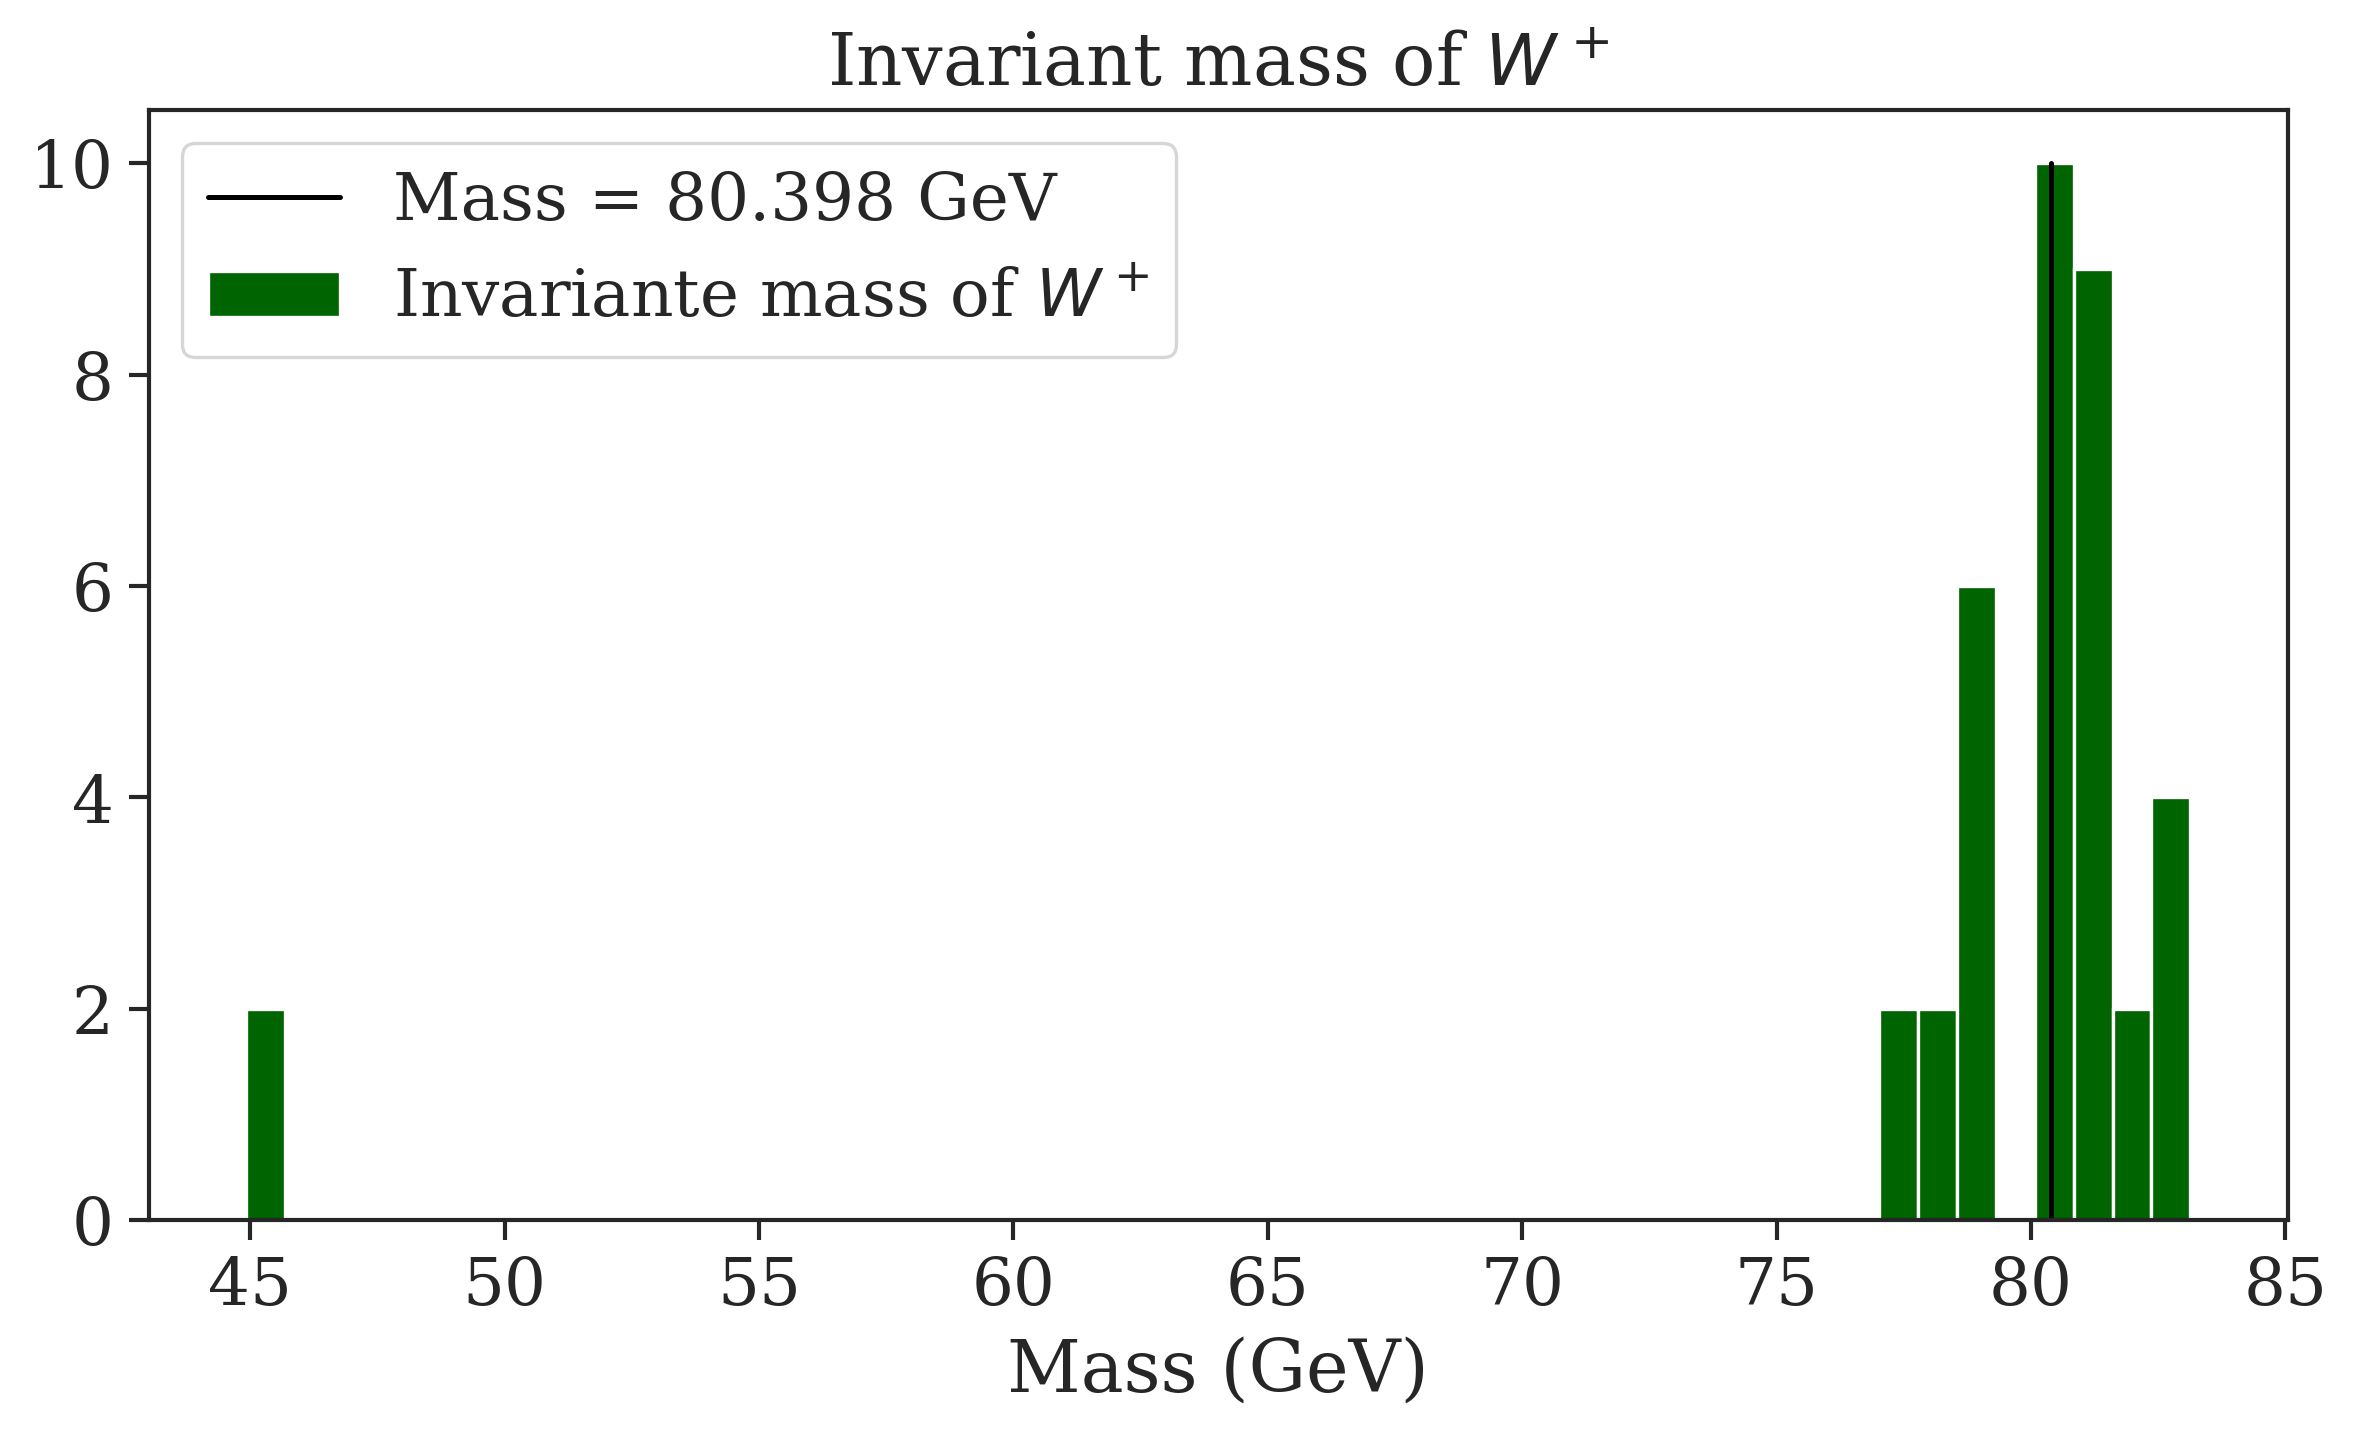

In [10]:
#Invariant mass
w_mass = invariant_mass('pp2ttbar_out.lhe',24)
w_mass = w_mass + invariant_mass('pp2ttbar_out.lhe',-24)
fig = plt.figure(figsize = [9.2,4.9], dpi = 300)
histogram = plt.hist(w_mass, bins = 50, color = 'darkgreen',label =r'Invariante mass of $W^+$')
plt.plot([80.398,80.398],[0,10], color = 'black', label = r'Mass = 80.398 GeV')

plt.xlabel(r'Mass (GeV)')
plt.title(r'Invariant mass of $W^+$')
plt.legend()
plt.show()

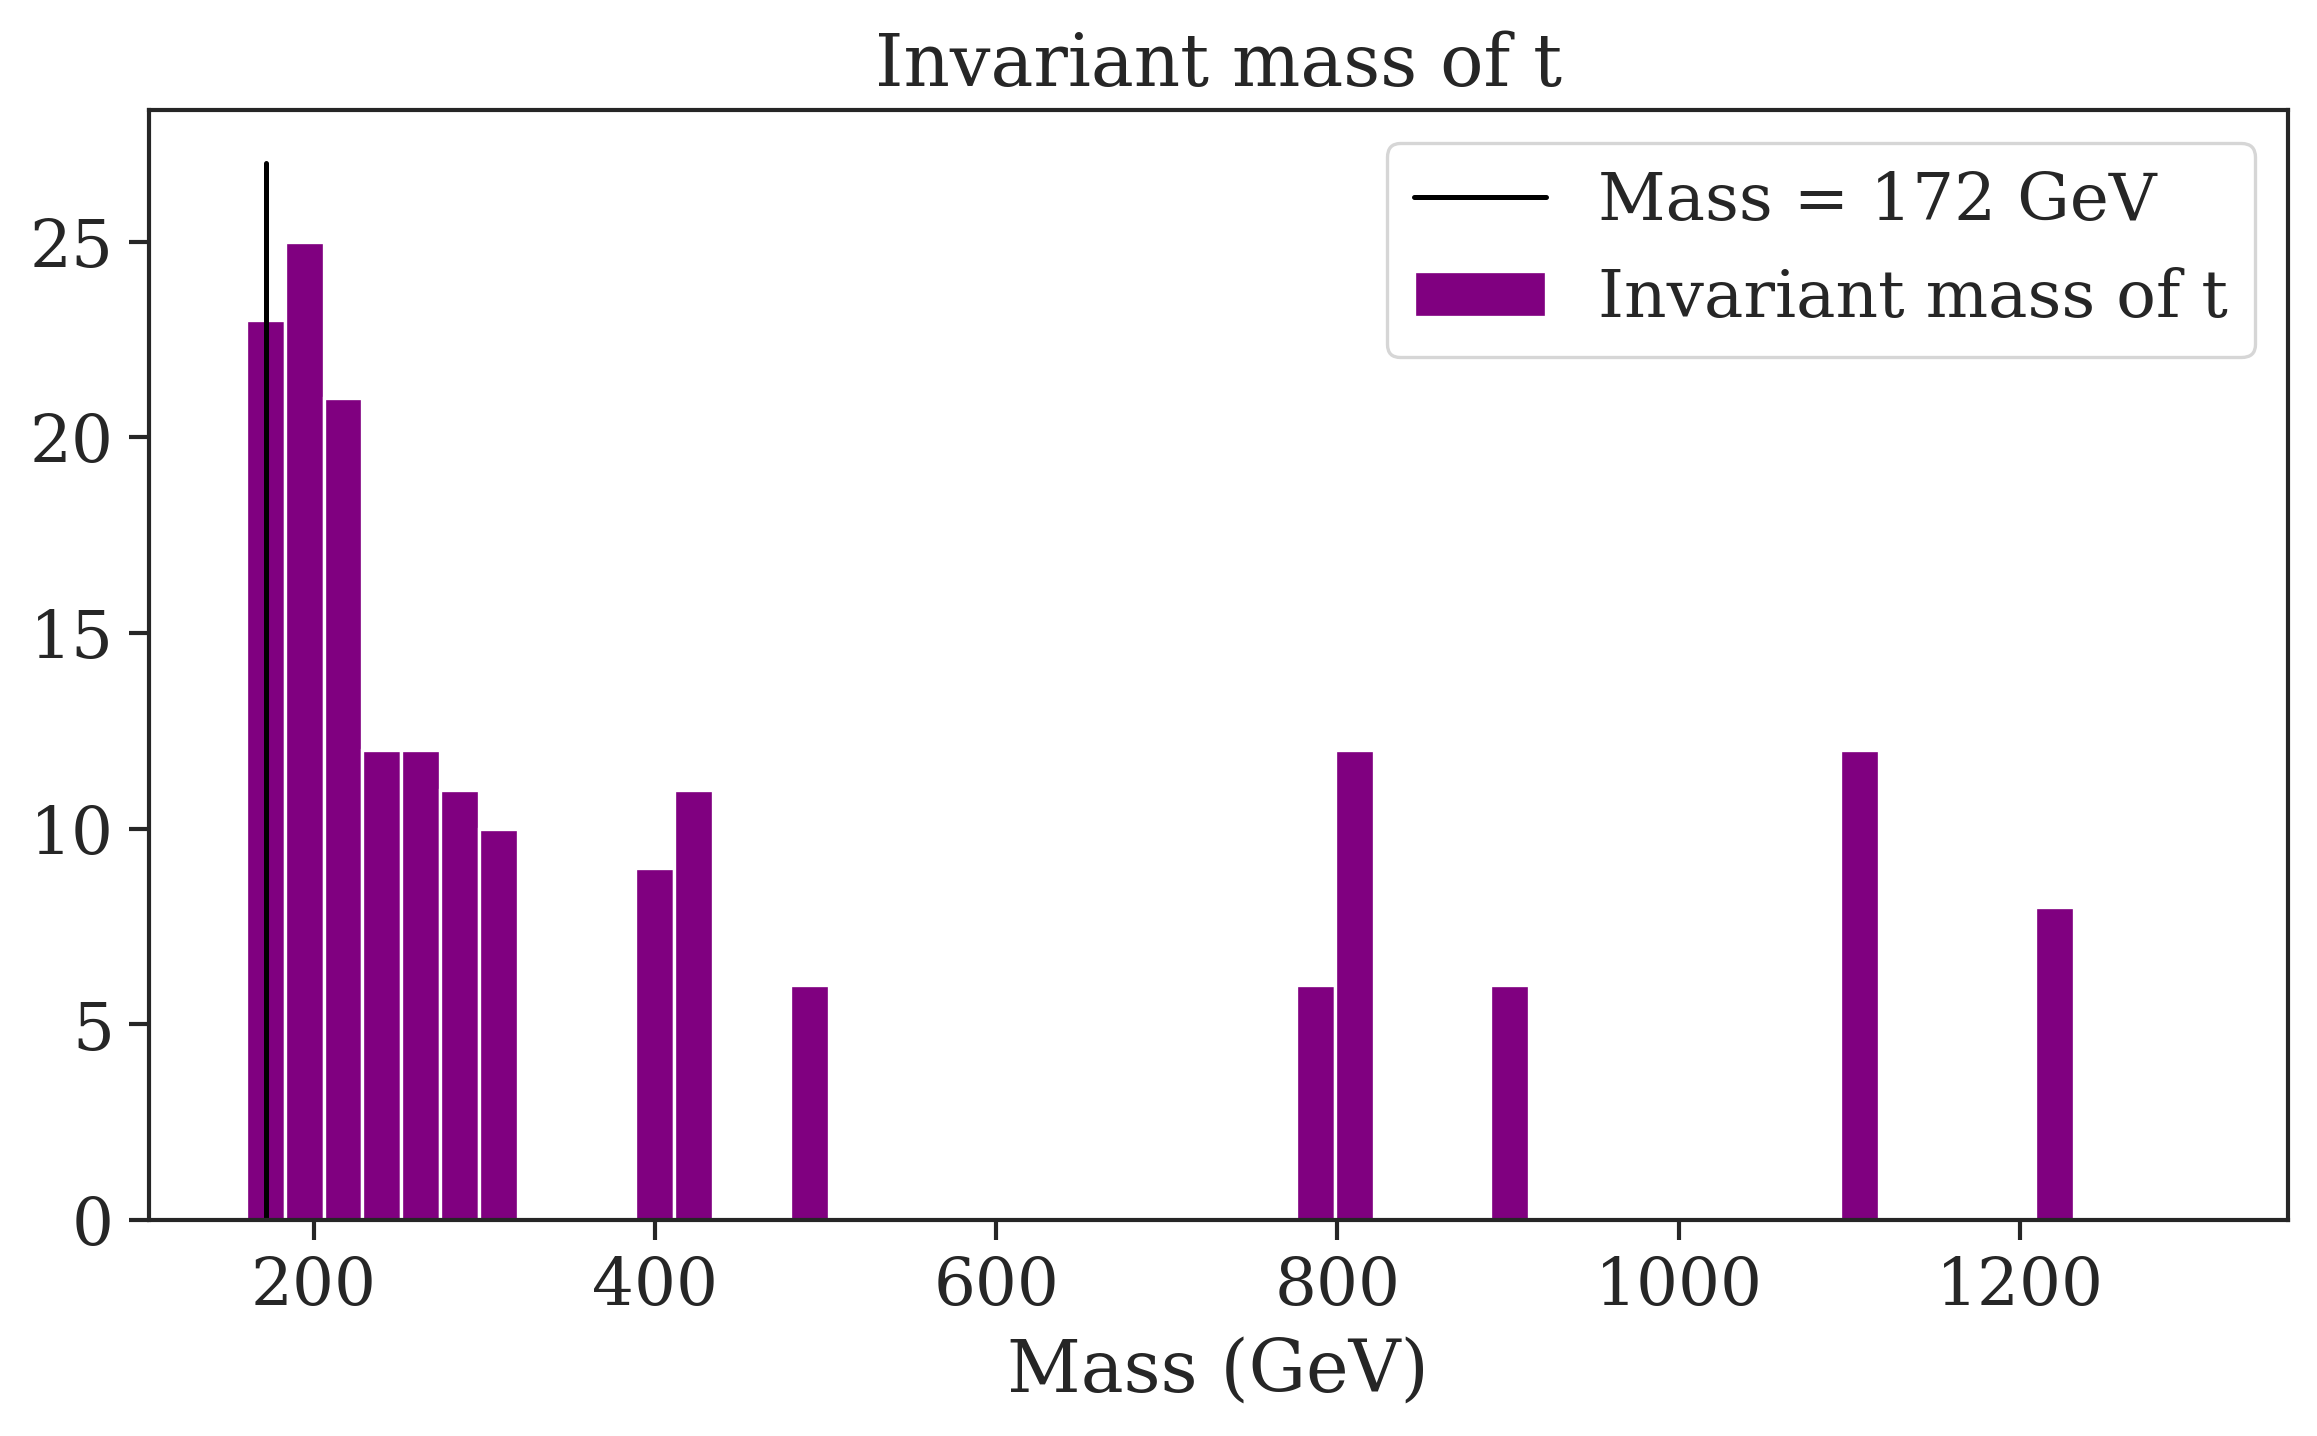

In [11]:
#Invariant mass
t_mass = invariant_mass('pp2ttbar_out.lhe',6)
t_mass = t_mass + invariant_mass('pp2ttbar_out.lhe',-6)
fig = plt.figure(figsize = [9.2,4.9], dpi = 300)
histogram = plt.hist(t_mass, bins = 50, range = [160,1300], color = 'purple', label = 'Invariant mass of t')
plt.plot([172,172],[0,27], color = 'black', label = r'Mass = 172 GeV')

plt.xlabel(r'Mass (GeV)')
plt.title(r'Invariant mass of t')
plt.legend()
plt.show()

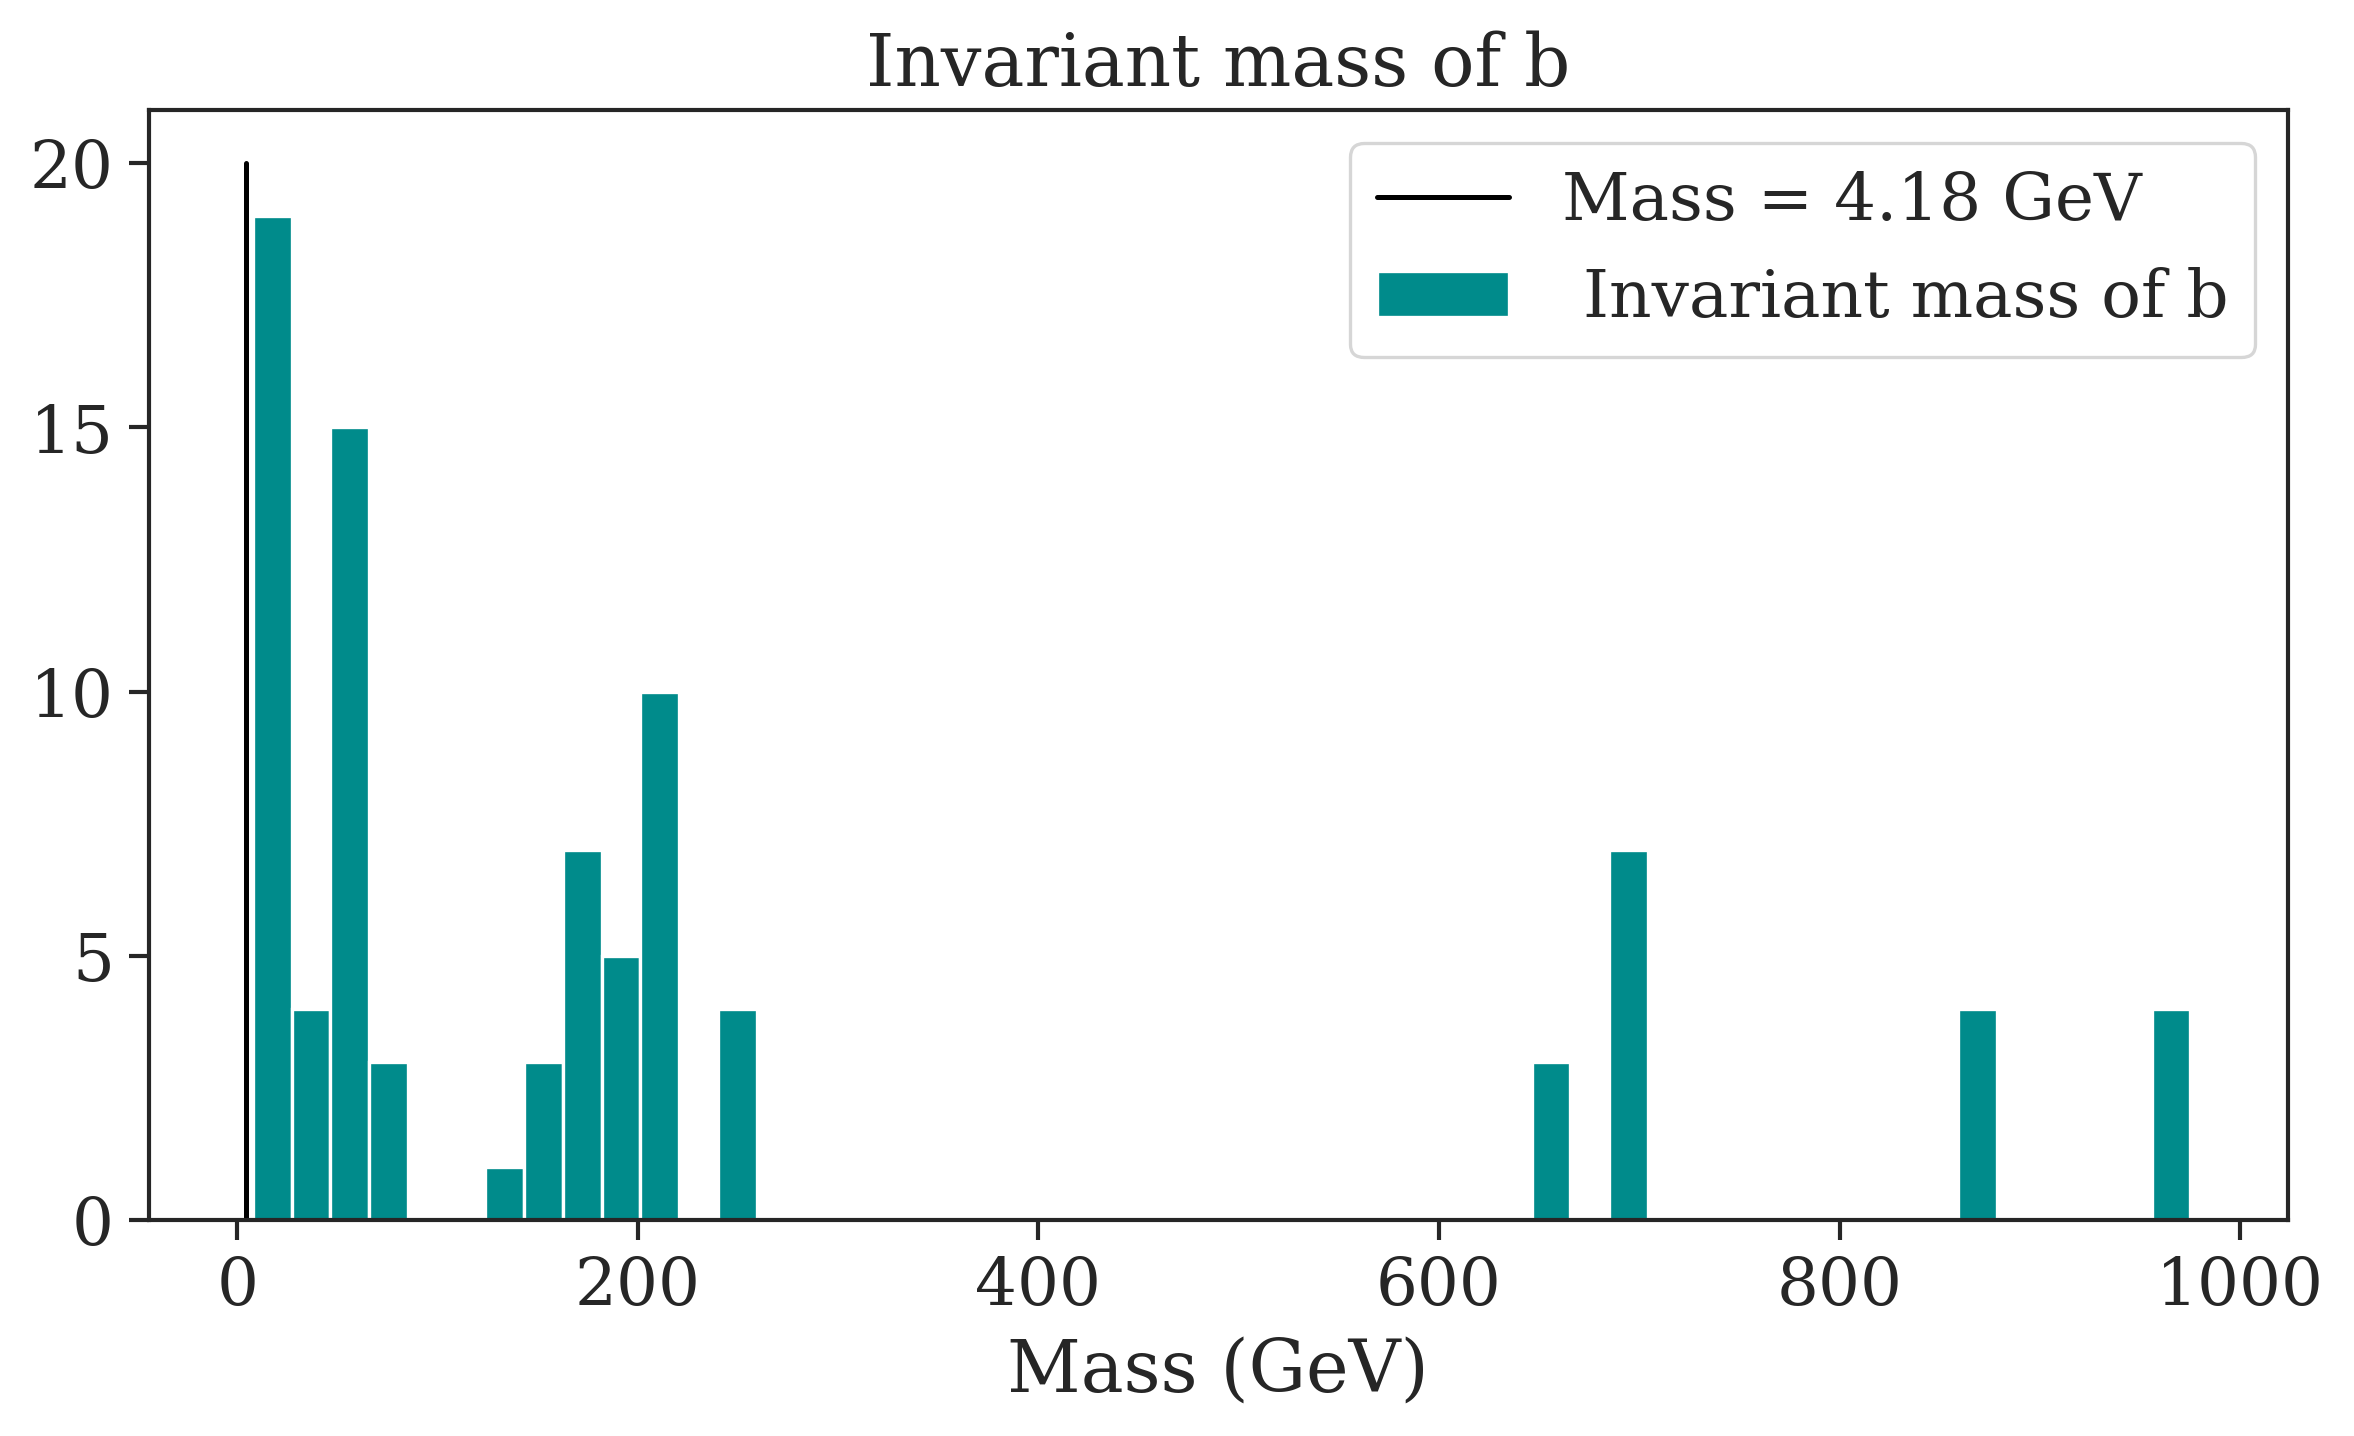

In [12]:
#Invariant mass
b_mass = invariant_mass('pp2ttbar_out.lhe',5)
b_mass = b_mass + invariant_mass('pp2ttbar_out.lhe',-5)
fig = plt.figure(figsize = [9.2,4.9], dpi = 300)
histogram = plt.hist(b_mass, bins = 50, color = 'darkcyan', label = r' Invariant mass of b')
plt.plot([4.18,4.18],[0,20], color = 'black', label = r'Mass = 4.18 GeV')

plt.xlabel(r'Mass (GeV)')
plt.title(r'Invariant mass of b')
plt.legend()
plt.show()

In [13]:
#Some inputs
file_name = 'pp2ttbar_out.lhe'
pdg_id = 6
num_events = 10

In [14]:
#Getting all generations for a guven pdg_id

full_daughters = []
for e in pylheV.readLHE(file_name):
    i = 0
    out = False
    while ((i != range(int(e.eventinfo.nparticles))) and out == False):
        if e.particles[i].id == pdg_id:
            daughters =  e.particles[i].daughters
            full_daughters.append(generations(e.particles,daughters))
            out = True
        i += 1
#Each component of the vector (full_daughters[i]) is a generation

In [15]:
#printing the generations for top (only first event)
for i,f in enumerate(full_daughters[0]):
    print(i+1,' generation: ', f)

1  generation:  [9]
2  generation:  [14]
3  generation:  [20]
4  generation:  [47]
5  generation:  [550]
6  generation:  [735, 736]
7  generation:  [739, 737, 738]
8  generation:  [751, 752, 742, 740, 741]
9  generation:  [753, 754, 755, 1082, 1084, 1083]
10  generation:  [758, 756, 757, 761, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125]
11  generation:  [767, 759, 760, 765, 766, 779, 1600, 1601, 1602, 1603, 1095, 1604, 1605, 1606, 1607, 1608, 1609, 1098, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1103, 1368, 1369, 1105, 1370, 1371, 1372, 1373, 1374, 1375, 1109, 1610, 1611, 1612, 1613, 1376, 1377, 1113, 1378, 1379, 1115, 1116, 1614, 1615, 1118, 1119, 1120, 1380, 1381, 1382, 1383, 1123, 1616, 1617, 1125]
12  generation:  [987, 762, 763, 764, 774, 775, 986, 978, 1876, 1877, 1601, 1602, 1603, 1095, 1604, 1605, 1878, 1879, 1880, 1881, 1882, 1883, 

In [16]:
#Getting the data from every particle in the generations (3 events)

gen = []
energy = []
momentum_x = []
momentum_y = []
momentum_z = []
for i in range(num_events):
    gen.append([])
    energy.append([])
    momentum_x = num_events*[[]]
    momentum_y.append([])
    momentum_z.append([])

for i,e in enumerate(pylheV.readLHE(file_name)):
    for j,f_dau in enumerate(full_daughters[i]):
        for k in range(len(f_dau)):
            energy[i].append((e.particles[f_dau[k]].e,particlesDict[abs(e.particles[f_dau[k]].id)]['name']))
            momentum_x[i].append(e.particles[f_dau[k]].px)
            momentum_y[i].append(e.particles[f_dau[k]].py)
            momentum_z[i].append(e.particles[f_dau[k]].pz)
            gen[i].append(j)
            



In [17]:
#Sum of components of 4-moment
g = 0
total_e = np.zeros(gen[g][len(gen[g])-1]+1)
total_px = np.zeros(gen[g][len(gen[g])-1]+1)
total_py = np.zeros(gen[g][len(gen[g])-1]+1)
total_pz = np.zeros(gen[g][len(gen[g])-1]+1)
px = np.array(momentum_x[g])
py = np.array(momentum_y[g])
pz = np.array(momentum_z[g])
energy1 = np.array(energy[g], dtype=[('energy', 'f4'), ('name', 'U10')])
for i,g in enumerate(gen[g]):
    
    total_e[g] += energy1['energy'][i]
    total_px[g] += px[i]
    total_py[g] += py[i]
    total_pz[g] += pz[i]
    

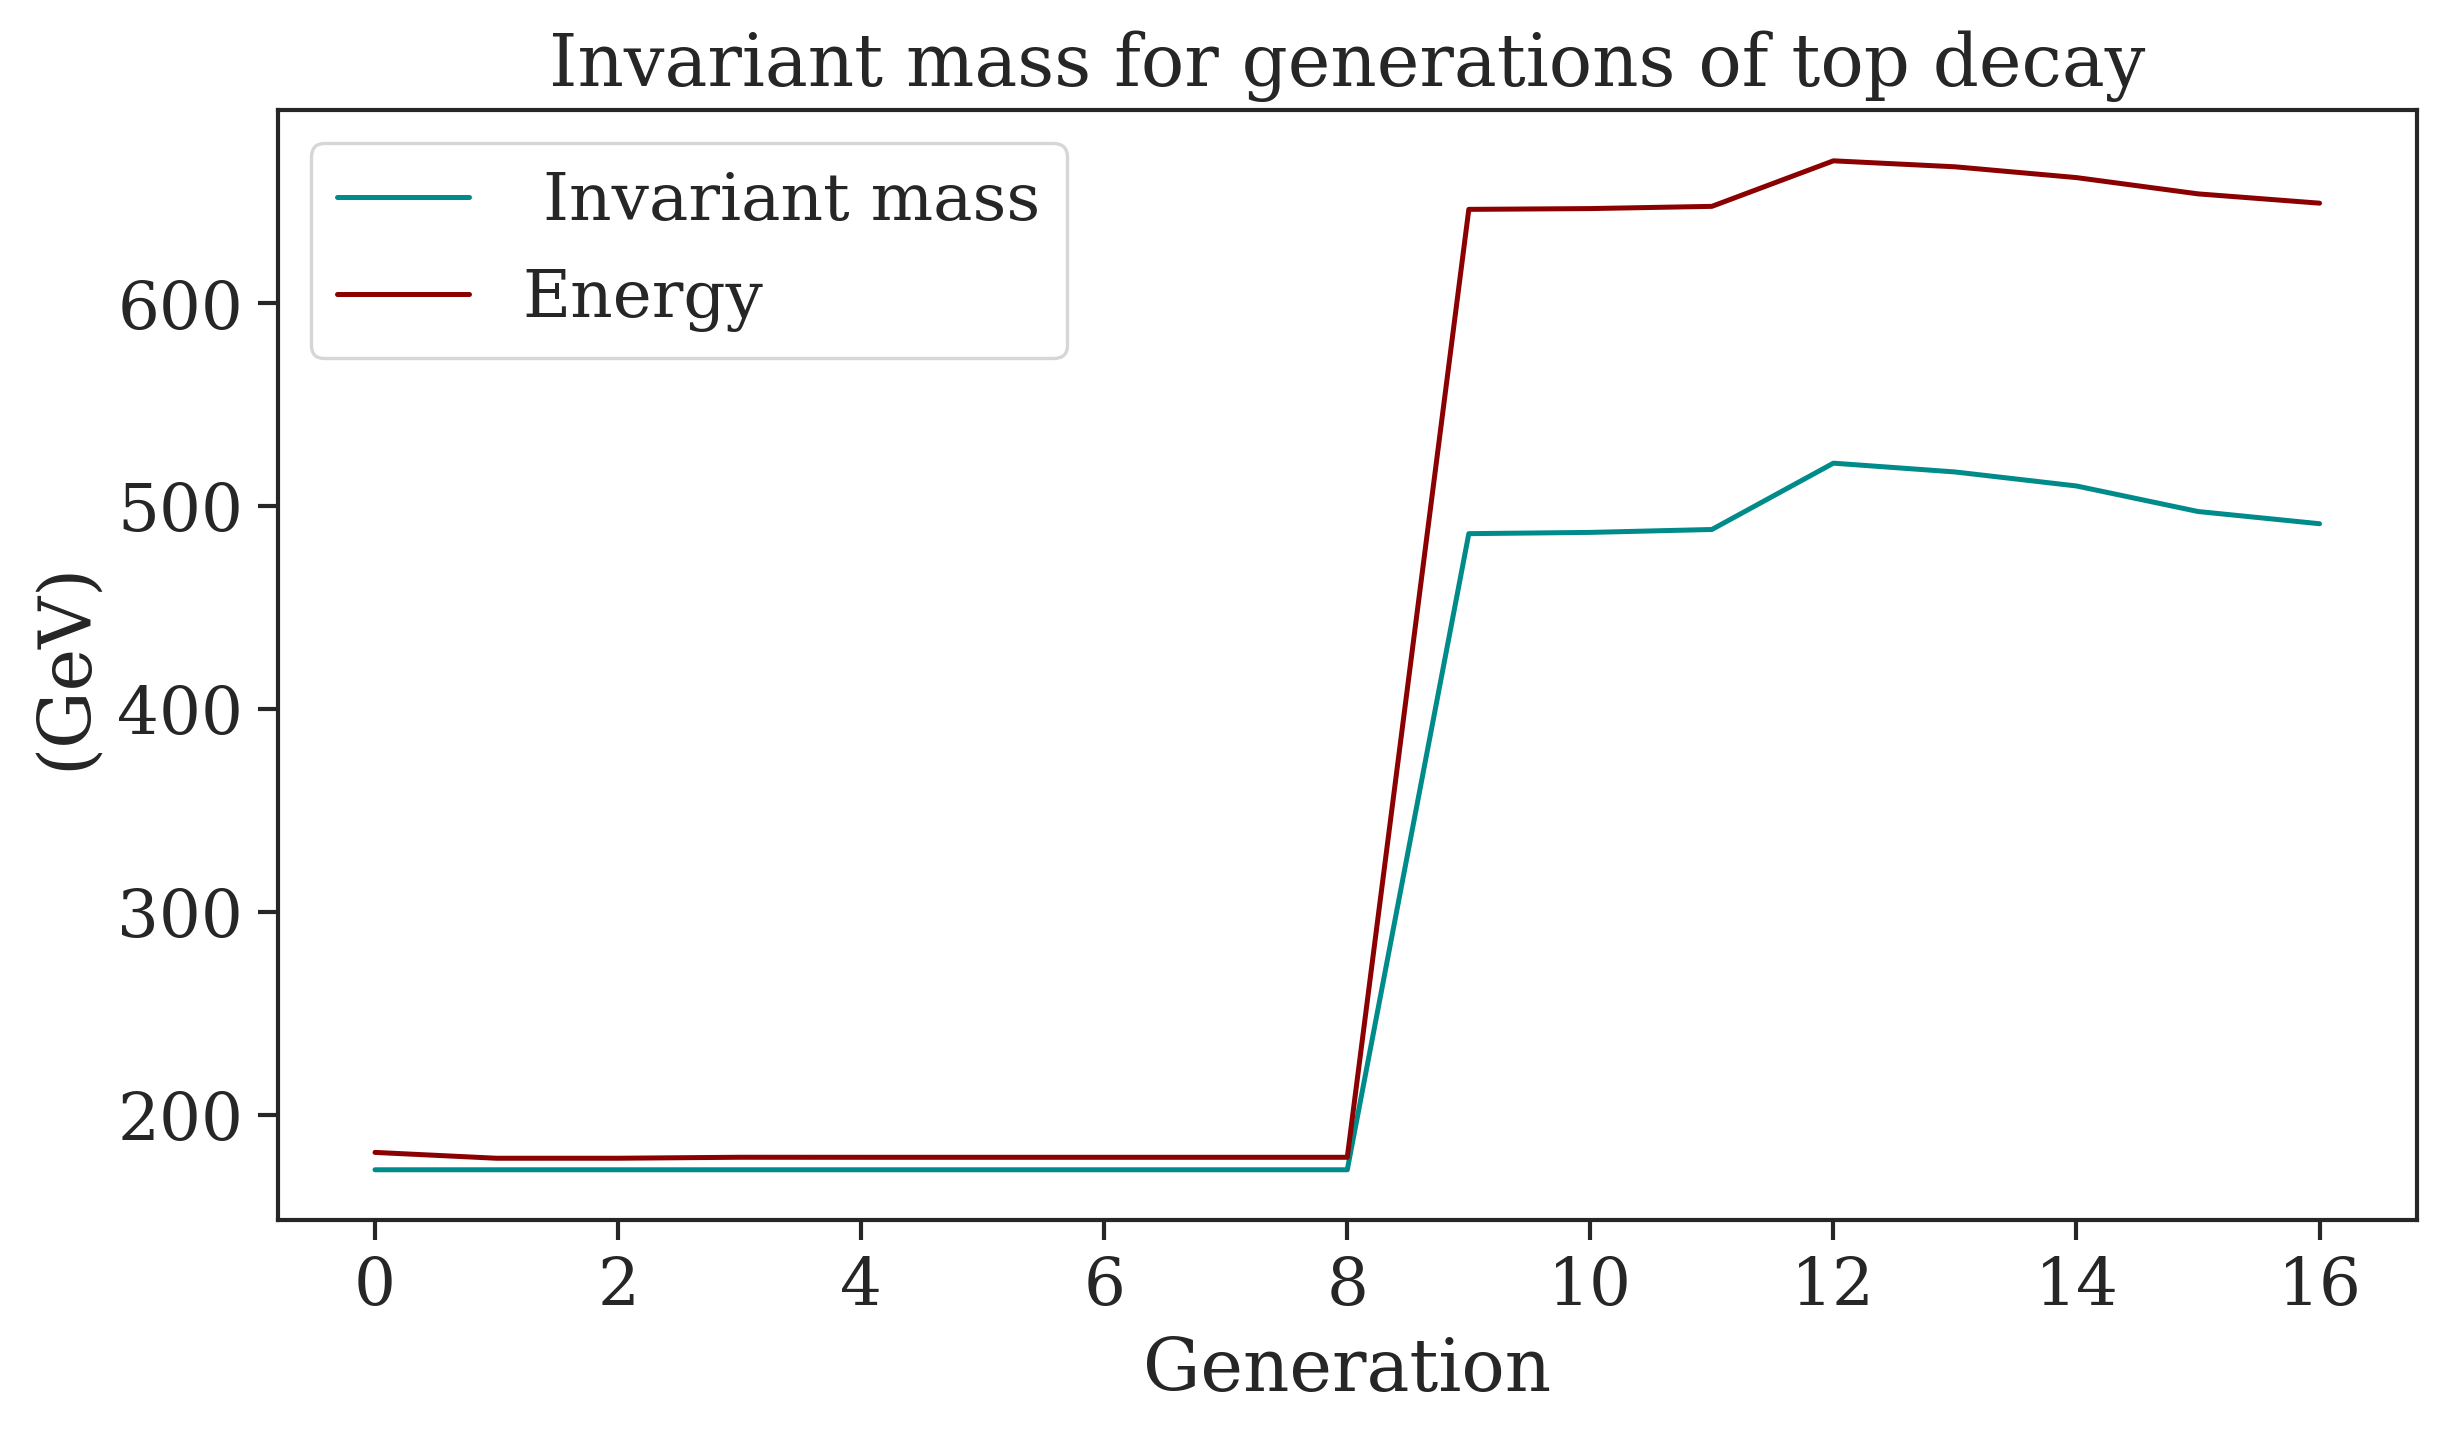

In [18]:
#Invariant mass
im = np.sqrt(total_e**2-total_px**2-total_py**2-total_pz**2)

fig = plt.figure(figsize = [9.2,4.9], dpi = 300)
plt.plot(im, color = 'darkcyan', label = r' Invariant mass')
plt.plot(total_e, color = 'darkred', label = r'Energy')

plt.xlabel(r'Generation')
plt.ylabel(r'(GeV)')
plt.legend()
plt.title(r'Invariant mass for generations of top decay')
plt.show()

In [19]:
#Looking for the invariant mass and the energy of every generation
print('invariant mass =',np.sqrt(total_e**2-total_px**2-total_py**2-total_pz**2))
print('energy =', total_e)

invariant mass = [173.00001915 173.0000526  172.9999796  173.00003984 172.99999441
 172.99995212 173.00000078 173.00000257 173.00000468 486.50595779
 487.12568128 488.56104539 521.24640041 516.91630423 510.00716416
 497.41929243 491.39464414]
energy = [181.55580139 178.67610168 178.68119812 179.17129517 179.14920044
 179.14915848 179.14920676 179.14920902 179.14921188 646.33217111
 646.71674329 647.8149684  670.25751971 667.31162956 661.98409407
 653.96953933 649.37922828]


In [24]:
energy1 = np.array(energy[0], dtype=[('energy', 'f4'), ('name', 'U10')])

fig = plt.figure(figsize = [40,100], dpi = 300)

plt.plot(gen[0],energy1['energy'],'o')

for i,pt in enumerate(energy1):
    plt.annotate(pt['name'],(0.1+ gen[0][i],pt['energy']))

plt.yscale('log')
plt.savefig('evolution1.pdf')
plt.show()

In [21]:
energy2 = np.array(energy[1], dtype=[('energy', 'f4'), ('name', 'U10')])

fig = plt.figure(figsize = [30,30], dpi = 300)

plt.plot(gen[1],energy2['energy'],'o')

for i,pt in enumerate(energy2):
    plt.annotate(pt['name'],(0.1+ gen[1][i],pt['energy']))

plt.yscale('log')
plt.savefig('evolution2.pdf')
plt.show()

In [22]:
energy3 = np.array(energy[2], dtype=[('energy', 'f4'), ('name', 'U10')])

fig = plt.figure(figsize = [30,30], dpi = 300)

plt.plot(gen[2],energy3['energy'],'o')

for i,pt in enumerate(energy3):
    plt.annotate(pt['name'],(0.1+ gen[2][i],pt['energy']))

plt.yscale('log')
plt.savefig('evolution3.pdf')
plt.show()

In [23]:
#This is the invariant mass of W+ in the top decay (event 5 in pp2ttbar_out.lhe)
print(np.sqrt((3.386139e+02)**2-(3.990570e+01)**2-(9.743385e+01)**2-(3.186792e+02)**2))

44.91236736420726
